In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from plaid.esmfold import esmfold_v1
esmfold = esmfold_v1()

In [24]:
data_dir = "/shared/amyxlu/data/cath/full/dompdb/"
cath_id = "3m1cA04"

from pathlib import Path
path = Path(data_dir) / cath_id 
with open(path, "r") as f:
    pdb_str = f.read()

In [25]:
from plaid import utils
utils.view_py3Dmol(pdb_str)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
seq_str = utils.parse_sequence_from_structure(pdb_str)

/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given elem

In [38]:
seq_str

'PRILVPITHNASYVVTHTPLPRGIGYKLTGVDVRRPLFITYLTATCEGHAREIEPKRLVRDLGLVGAVFLRYTPAGEVMSVLLVDTDATQQQLAQGPVAGTPNVFSSDVPSVALLLFPNGTVIHLLAFDTLP'

In [28]:
esmfold = esmfold.cuda()
pred_structure = esmfold.infer_pdb(seq_str)
# pred_structure = esmfold.infer_pdb(seq_str)
# pred_pdb_str = utils.output_to_pdb(pred_structure)

In [29]:
utils.view_py3Dmol(pred_structure)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
utils.run_tmalign(pred_structure, pdb_str)

saved query to /home/amyxlu/.tmp/query.pdb
saved reference to /home/amyxlu/.tmp/reference.pdb


0.31547

In [31]:
from Bio.PDB import PDBParser
import numpy as np

def calculate_distance(residue1, residue2):
    """Calculate the distance between the center of masses of two residues."""
    diff_vector = residue1["CA"].coord - residue2["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def build_contact_map(pdb_file, threshold=5.0):
    """Build a contact map from a PDB file with a specified distance threshold."""
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]  # Assuming we are working with the first model

    residues = [residue for residue in model.get_residues() if residue.get_id()[0] == ' ']
    n = len(residues)
    contact_map = np.zeros((n, n), dtype=int)

    for i, residue1 in enumerate(residues):
        for j, residue2 in enumerate(residues):
            if calculate_distance(residue1, residue2) < threshold:
                contact_map[i, j] = 1

    return contact_map

# Replace 'your_pdb_file.pdb' with your PDB file path
contact_map = build_contact_map(path)

# Now you can use contact_map for further analysis or visualization


/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/amyxlu/miniconda3/envs/kdif/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given elem

<Axes: >

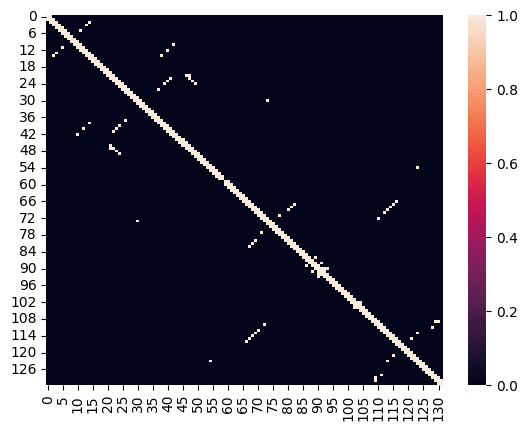

In [32]:
import seaborn as sns
sns.heatmap(contact_map)

In [39]:
import torch

device = torch.device("cuda:2")
esmfold.to(device)
esmfold.eval()
outputs = esmfold.infer(seq_str)

In [42]:
outputs['plddt'].mean()

tensor(30.2747, device='cuda:2')